## Table of contents
1. [Create Train and Validation data split](#split_data)
2. [Exploratory Data Analysis](#EDA)
3. [Baseline Models](#baseline)
    1. [K-Nearest Neighbor Model](#KNN)
    2. [Naive Bayes and SVM Model](#NBSVM)
3. [Simple CNN Model](#simple_cnn)
4. [CNN Model With Data Augmentation](#cnn_data_augmentation)
5. [VGG-16 CNN Model With Data Augmentation](#cnn_vgg16_data_augmentation)
6. [InceptionV3 CNN Model With Data Augmentation](#cnn_inceptionV3_data_augmentation)
7. [Multi-Layer Perceptron with Batch Normalization](#MLPBN)
8. [Multi-Layer Perceptron with Batch Normalization & Dropout](#MLPBND)


In [1]:
# Importing Libraries
import os
import sys
import joblib
import copy
import cv2
from glob import glob
import shutil
import warnings
warnings.filterwarnings('ignore')
import itertools

# Importing pandas libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid", {'axes.grid' : False})

# Importing Sklearn libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.cross_validation import KFold
from scipy.misc import imread
from scipy.cluster import vq

# Importing Keras libraries
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras.optimizers import SGD
from keras import __version__ as keras_version
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, History, ModelCheckpoint
from keras.layers.core import Flatten, Dense, Dropout, Reshape, Lambda
from keras.layers.normalization import BatchNormalization
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


## Create Train and Validation data split <a name="split_data"></a>

In [2]:
#check if a train and validation set is already created if not create them else pass
try:
    #get file paths for all images in training set
    img_path_list = glob("train_split/*/*")
    if not len(img_path_list)==3019:
        
        train_split = os.mkdir("train_split")
        val_split = os.mkdir("val_split")
        #get the 8 classes present
        classes = os.listdir("train/")
        #make the directories based on classes
        for fish_species in classes:
            os.mkdir("train_split/"+fish_species)
            os.mkdir("val_split/"+fish_species)

        for species in classes: 
            #get all file paths for original train data in train set
            fish_root_list = os.listdir('train/'+species+'/')
            split_index = int(0.8*len(fish_root_list))
            #shuffling the data
            np.random.shuffle(fish_root_list)
            #create a training and validation set
            train_list = fish_root_list[:split_index]
            valid_list = fish_root_list[split_index:]
            #copy images from kaggle training set to our train&validation set
            for image in train_list :
                shutil.copy('train/'+species+'/' + image,"train_split/" + species + '/' + image)
            for image in valid_list:
                shutil.copy('train/'+species+'/' + image,"val_split/" + species + '/' + image)
except:
    pass

# define a function for plotting the confusion matrix
def show_confusion_matrix(conf_matrix, normalize=False, cmap=plt.cm.Blues):
    plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
    #set title for the conf matrix
    plt.title('Confusion matrix')
    #choose color bar to indicate number of images more images more dark the color
    cbar = plt.colorbar(fraction=0.046, pad=0.04)
    #set the color bar to be rotated low images at bottom and high no of images at top
    cbar.set_label('Number of images', rotation=270, labelpad=30, fontsize=12)
    #arrange the labels on y axis to be at 45 degrees
    plt.xticks(np.arange(len(os.listdir('train/'))), os.listdir('train/'), rotation=45)
    #arrange the labels on y axis to be horizonal
    plt.yticks(np.arange(len(os.listdir('train/'))), os.listdir('train/'))
    #display values in the conf matrix
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        plt.text(j, i, conf_matrix[i, j], horizontalalignment="center", color="white" if conf_matrix[i, j] > conf_matrix.max() / 2. else "black")

    plt.tight_layout()
    #label the x axis
    plt.ylabel('Actual label')
    #label the yaxis
    plt.xlabel('Predicted label')

## Exploratory Data Analysis <a name="EDA"></a>

In [3]:
#initialize path for the training data and initialize fish classes
path, classes = os.getcwd() + '\\' + 'train\\', ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
count_dict, different_file_sizes = {}, {}
X_train, X_train_id, y_train = [], [], []
figs=[]

#resizing images to 256x256 for uniformity
get_im_cv2 = lambda path: cv2.resize(cv2.imread(path), (256, 256), cv2.INTER_LINEAR)

#creating train set 
def create_train_data(file,index):
    #seperate out features and labels
    X_train.append(get_im_cv2(file))
    X_train_id.append(file)
    y_train.append(index)

#traverse the files for each class and explore the data
for fish_species in classes:
    i=1
    idx = classes.index(fish_species)
    #use glob to get a list of file paths
    g = glob(path + fish_species + '\\' + '*.jpg')
    count_dict[fish_species] = len(g)
    for img_file in g:
        #append a single image for each fish species in a list to display later
        if i==1: figs.append((fish_species,imread(img_file)))
        i=0
        size = "_".join(map(str,list(imread(img_file).shape)))
        #get a list of different sizes present in the training set
        different_file_sizes[size] = different_file_sizes.get(size,0) + 1
        create_train_data(img_file,idx)

#make a deep copy of the features and labels for later use
orig_X_train = copy.deepcopy(X_train)
orig_train_id = copy.deepcopy(X_train_id)
orig_train_target = copy.deepcopy(y_train)

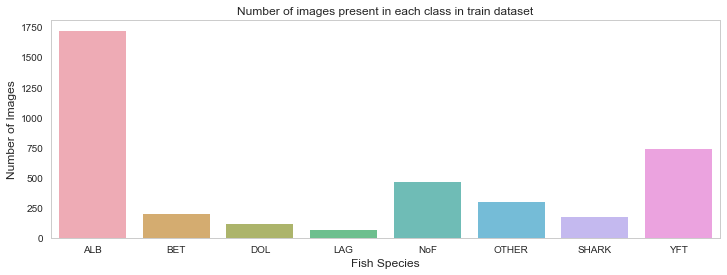

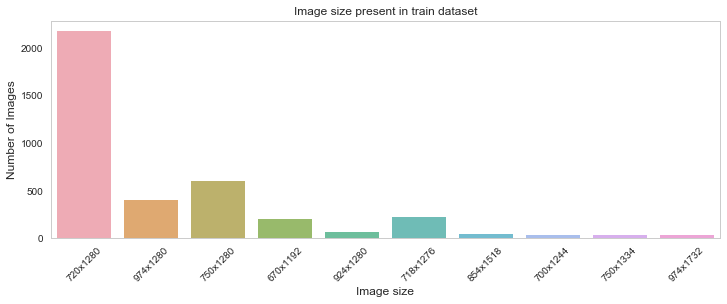

Displaying how each species of fish looks like


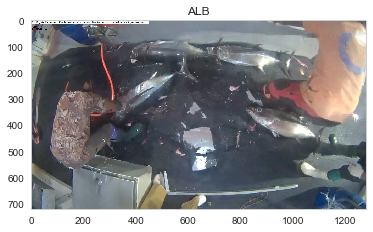

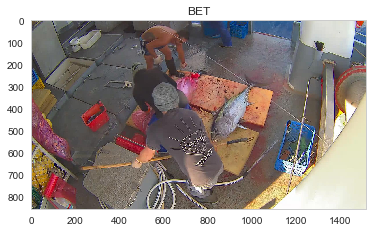

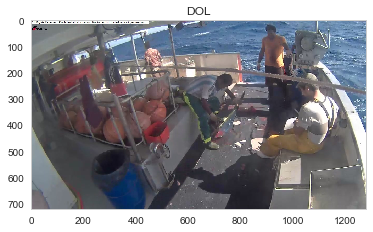

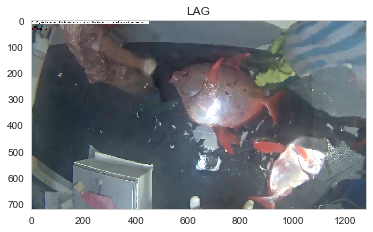

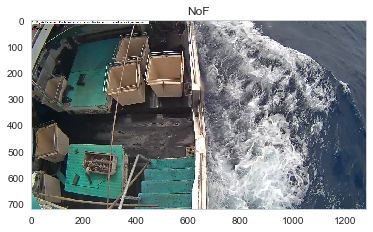

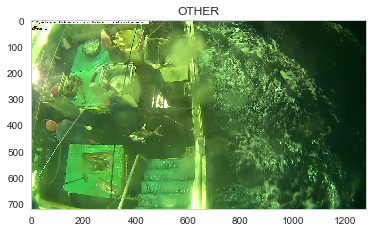

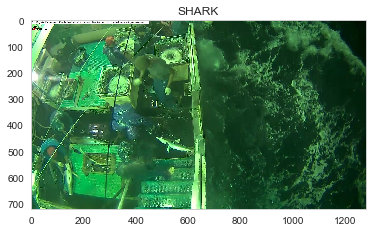

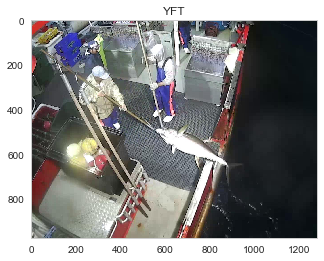

In [4]:
#checking class imbalance    
plt.figure(figsize=(12,4))
#Display the number of images present in each class
sns.barplot(list(count_dict.keys()), list(count_dict.values()), alpha=0.8)
plt.xlabel('Fish Species', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title("Number of images present in each class in train dataset")
plt.show()

#checking for different file sizes in data
plt.figure(figsize=(12,4))
cleaned_size=[str(key.split("_")[0])+"x"+str(key.split("_")[1]) for key in list(different_file_sizes.keys())]
# Display the different sizes for the images present in the data
sns.barplot(cleaned_size, list(different_file_sizes.values()), alpha=0.8)
plt.xlabel('Image size', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title("Image size present in train dataset")
plt.xticks(rotation=45)
plt.show()

#Displaying how each species of fish looks like
print("Displaying how each species of fish looks like")
for fig in figs:
    plt.title(fig[0])
    plt.imshow(fig[1])
    plt.show()
    


## Baseline Models <a name="baseline"></a>

In [5]:
#get list of all image paths present in the dataset
img_path_list = glob("train/*/*")
train_target = copy.deepcopy(orig_train_target)
#perform one hot encoding of the labels ie convert categorical to numerical values
labels = LabelEncoder().fit_transform(train_target)

#a fucntion for fitting the model to train set and predicting on the validation set
def fit_and_predict(features, labels, model):
    #use the train_test split library from sklearn to create a 75:25 train test split
    X_train,X_val,y_train,y_val = train_test_split(features,labels,test_size = 0.25, random_state = 42)
    model.fit(X_train,y_train)
    #predict on the fitted model
    preds_validation = model.predict(X_val)
    #predict_proba helps in getting the predictions as a probability between 0 & 1
    preds_validation_proba = model.predict_proba(X_val)
    print("Predictions on validation set")
    print("Accuracy score on Validation set is: ", accuracy_score(y_val,preds_validation))
    print("F1 score on Validation set is: ", f1_score(y_val,preds_validation,average="weighted"))
    print("Log loss score on Validation set is: ", log_loss(y_val,preds_validation_proba))
    print("\n Accuracy-score: ",accuracy_score(y_val,preds_validation))
    conf_matrix = confusion_matrix(y_val,preds_validation)
    #plot figure
    plt.figure()
    #display confusion matrix
    show_confusion_matrix(conf_matrix)
    #show plot
    plt.show()

### K-Nearest Neighbor Model <a name="KNN"></a>

In [6]:
#method for k-nearest neighbor model
def knn_model(labels):

    # Get the color histograms for the images

    features = []
    # traverse the list of image paths 
    for img_path in img_path_list:
        #get histogram of colors by making use of the calcHist method provided by cv2
        hist = cv2.calcHist([cv2.cvtColor(cv2.imread(img_path),cv2.COLOR_BGR2HSV)],[0,1,2],None,(8,8,8),[0,256,0,256,0,256])
        #its important to normalize the histogram
        cv2.normalize(hist,hist)
        #and we add the the features in the form of histograms to our features list
        features+=hist.flatten(),

    #setting the nearest neighbors to 2
    model = KNeighborsClassifier(n_neighbors = 2, n_jobs = -1)
    fit_and_predict(features, labels, model)
    #load the paths for images present in the test dataset from test stage1&2
    test_files = glob('test_stg1/*')
    test_files.extend(glob('test_stg2/*'))
    #get the file names for all test file so that we can add them to the submission.csv file
    test_file_names = [im for im in os.listdir('test_stg1/')]
    test_file_names.extend(glob('test_stg2/*'))
    #extract the features from testset images using the same color histograms as we did for train images 
    test_features = []
    for i,img_path in enumerate(test_files):
        #calculate color histograms for test set images
        hist = cv2.calcHist([cv2.cvtColor(cv2.imread(img_path),cv2.COLOR_BGR2HSV)],[0,1,2],None,(8,8,8),[0,256,0,256,0,256])
        cv2.normalize(hist,hist)
        #add test image features to the test features list
        test_features+=hist.flatten(),
    
    #predict on the test set using predict proba which gives predictions in form of probabilities
    preds = model.predict_proba(test_features)
    clipped_preds = np.clip(preds,(1-0.82)/7,0.82)
    #make a submission dataframe as kaggle accepts it
    submission = pd.DataFrame(clipped_preds, columns= os.listdir("train/"))
    #insert test image file names in submission data frame as first column
    submission.insert(0, 'image', test_file_names)
    submission.head()
    #convert the submission dataframe into a csv file with a name
    submission.to_csv("K_neighbors_submission.csv",index = False)

#call the knn baseline model
knn_model(labels)

Predictions on validation set
Accuracy score on Validation set is:  0.925925925926
F1 score on Validation set is:  0.924331806322
Log loss score on Validation set is:  1.51110255756


### Naive Bayes and SVM Model <a name="NBSVM"></a>

In [7]:
# define a baseline model using Naive Bayes and SVM model
def naive_bayes_and_svm_model(img_path_list, labels):
    #making a dictionary for the classes present in dataset
    CLASSES = {
        'ALB': 1,
        'BET': 2,
        'DOL': 3,
        'LAG': 4,
        'NoF': 5,
        'OTHER': 6,
        'SHARK': 7,
        'YFT': 8
    }
    
    #descriptor list having all the key point features and strongest features using FAST algorithm in ORB
    descriptor_list = [(f, np.float32(cv2.ORB_create().detectAndCompute(cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB), None)[1])) for f in img_path_list]

    #get the first descriptor present for initialization
    arrange_descriptors = descriptor_list[0][1]
    #traverse the descriptor list
    for _, d in descriptor_list[1:]:
        #arrange the descriptors in a vertical stack using numpy
        arrange_descriptors = np.vstack((arrange_descriptors, d))

    print("\nTraining phase\n")
    #find the cluster centroid
    middle_pt = cv2.kmeans(arrange_descriptors, 3, None, (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0), 10, cv2.KMEANS_RANDOM_CENTERS)[2]
    #get image features on the bases of kmeans clustering the descriptors
    img_features = np.zeros((len(img_path_list), 3), "float32")
    for i in range(len(img_path_list)):
        #get the word and distance between each cluster point and centroid
        w, dist = vq.vq(descriptor_list[i][1], middle_pt)
        #traverse each word
        for _ in w:
            #inc value by 1 for each img features for every image for every word
            im_features[i][_] += 1

    # Scaling the values of features
    stdSlr_features = StandardScaler().fit(img_features)
    #transform the images using standard scaler transform
    img_features = stdSlr_features.transform(img_features)
    #define gaussuan naive bayes and svm model
    model1, model2 = GaussianNB(), svm.SVC(kernel='rbf', C = 1.0, probability=True)
    fit_and_predict(im_features, labels, model1)
    fit_and_predict(im_features, labels, model2)
    #get all test file image paths in a list from test stage 1
    test_files = glob('test_stg1/*')
    #extend the list with file paths from images in stage 2
    test_files.extend(glob('test_stg2/*'))
    #get all test file image names in a list
    test_file_names = [im for im in os.listdir('test_stg1/')]
    test_file_names.extend(glob('test_stg2/*'))
    #print(test_file_names)
    #apply the same treatement as applied on train images to test images
    test_des_list = [(f, np.float32(cv2.ORB_create().detectAndCompute(cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB), None)[1])) for f in test_files]

    #get the first descriptor present for initialization
    test_descriptors = test_des_list[0][1]
    #traverse the descriptor list
    for _, d in test_des_list[1:]:
        #arrange the descriptors in a vertical stack using numpy
        test_descriptors = np.vstack((test_descriptors, descriptor))

    print("\nTesting Phase\n")
    #find the cluster centroid
    middle_pt=cv2.kmeans(test_descriptors, 3, None, (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0), 10, cv2.KMEANS_RANDOM_CENTERS)[2]
    #get image features on the bases of kmeans clustering the descriptors
    test_im_features = np.zeros((len(test_files), 3), "float32")
    for i in range(len(test_files)):
        #get the word and distance between each cluster point and centroid
        w, dist = vq.vq(test_des_list[i][1], middle_pt)
        #traverse each word
        for _ in w:
            #inc value by 1 for each img features for every image for every word
            test_im_features[i][_] += 1

    # Scaling the values of features
    stdSlr = StandardScaler().fit(test_im_features)
    #transform the images using standard scaler transform
    test_im_features = stdSlr.transform(test_im_features)
    #predict on the test set using predict proba which gives predictions in form of probabilities
    preds1 = model1.predict_proba(test_im_features)
    clipped_preds1 = np.clip(preds1,(1-0.82)/7,0.82)
    #make a submission dataframe as kaggle accepts it
    submission1 = pd.DataFrame(clipped_preds1, columns= os.listdir("train/"))
    #insert test image file names in submission data frame as first column
    submission1.insert(0, 'image', test_file_names)
    submission1.head()
    #convert the submission dataframe into a csv file with a name
    submission1.to_csv("GaussianNB_submission.csv",index = False)
    #predict on the test set using predict proba which gives predictions in form of probabilities
    preds2 = model2.predict_proba(test_im_features)
    clipped_preds2 = np.clip(preds2,(1-0.82)/7,0.82)
    #make a submission dataframe as kaggle accepts it
    submission2 = pd.DataFrame(clipped_preds2, columns= os.listdir("train/"))
    #insert test image file names in submission data frame as first column
    submission2.insert(0, 'image', test_file_names)
    submission2.head()
    #convert the submission dataframe into a csv file with a name
    submission2.to_csv("SVM_submission.csv",index = False)

#call the naive bayes and svm model
naive_bayes_and_svm_model(img_path_list, labels)


Training phase

Predictions on validation set
Accuracy score on Validation set is:  0.478306878307
F1 score on Validation set is:  0.342088927776
Log loss score on Validation set is:  1.57797117663
Predictions on validation set
Accuracy score on Validation set is:  0.496296296296
F1 score on Validation set is:  0.344185690199
Log loss score on Validation set is:  1.49661701166

Testing Phase



### Transform Data

In [ ]:
#plot graphs for model accuracy and log loss for train and validation sets
def plot_graphs(history):    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    #using the history object returned from model
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    #side by side comparison of accuracy and log loss on train and validation set
    plt.subplot(1, 2, 2)
    #using the history object returned from model
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

#preprocess image using keras preprocess input library
convert_img = lambda i: preprocess_input(np.expand_dims(image.img_to_array(image.load_img(i, target_size = (256,256))), axis = 0))
#get file names for images in test stage 1 & 2
test_file_names = [im for im in os.listdir('test_stg1/')]
test_file_names.extend(glob('test_stg2/*'))
#check if train and validation set features are already stored in npy files
try:
    train_img_features, valid_img_features, test_data = np.load('train_set.npy'), np.load('valid_set.npy'), np.load("test_set.npy")
except:
# if features are not saved in files traverse the data and make the feature file
    np.save("train_set.npy",np.vstack([convert_img(i) for i in glob("train_split/*/*")]))
    #traverse image paths and preprocess image, then sve it in a vertical stack using numpy
    np.save("valid_set.npy",np.vstack([convert_img(i) for i in glob("val_split/*/*")]))
    #load features for train and validate set from files
    train_img_features, valid_img_features = np.load('train_set.npy'), np.load('valid_set.npy')
    print("...")
    # Get the test image files from stage1&2
    test_files = glob('test_stg1/*')
    test_files.extend(glob('test_stg2/*'))
    #preprocess the test files same way as we processed train and validation set image files
    np.save("test_set.npy",np.vstack([convert_img(i) for i in test_files]))
    #load test features
    test_data = np.load("test_set.npy")

train_target_labels, valid_target_labels = [], []
#traverse the fish classes to get labels for the images present in train and test data
for fish_species in os.listdir("train_split/"):
    train_target_labels.extend([fish_species]*len(os.listdir("train_split/"+fish_species+'/')))
    valid_target_labels.extend([fish_species]*len(os.listdir("val_split/"+fish_species+'/')))
#one hot encode the labels
encoded_train, encoded_valid = to_categorical(LabelEncoder().fit_transform(train_target_labels)), to_categorical(LabelEncoder().fit_transform(valid_target_labels))
print("...")

def validate_conf_matrix(model):
    true_valid_target_labels = []
    #traverse categories
    for fish_species in os.listdir("train_split/"):
        true_valid_target_labels.extend([fish_species]*len(os.listdir('val_split/'+fish_species+'/')))
    #store predicted labels in dataframe 
    valid_preds = pd.DataFrame(model.predict(valid_img_features, batch_size=5, verbose=1), columns= os.listdir("train_split/"))
    #round to one dicimal pt
    valid_preds = valid_preds.round(1)
    #process labels
    pred_labels = [row.index(max(row)) for row in [row for row in valid_preds.itertuples(index = False)]]
    #encode labels
    encoder = LabelEncoder()
    encoder.fit(os.listdir("train/"))
    #display accuracy
    print("\n Accuracy-score: ",accuracy_score(true_valid_target_labels,encoder.inverse_transform(pred_labels)))
    plt.figure()
    #display confusion matrix
    show_confusion_matrix(confusion_matrix(true_valid_target_labels,pred_labels))
    plt.show()
    

## Simple CNN Model <a name="simple_CNN"></a>

In [18]:
# define a convolutional neural network model for fish classification
def basic_cnn_model(orig_X_train, orig_train_id, orig_train_target):

    def create_model():
        # we creat a cnn model by initalizing it with a sequential model
        model = Sequential()
        #add a conv layer having 16 filters with window size of 2x2 and stride 1 with padding
        model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(256, 256, 3)))
        #add a max pooling layer having a window of 2x2
        model.add(MaxPooling2D(pool_size=2))
        #add another convolution layer helps getting the model deeper
        model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
        #adding another max pooling layer has a effect of halving the dimensions ie we loose spatial info
        model.add(MaxPooling2D(pool_size=2))
        #add conv layer with 64 filters and relu is used as activation fn for each conv layer
        model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=2))
        #flatten the matrix to a vector so that it can be attached to MLP
        model.add(Flatten())
        #add a fully connected layer with 512 nodes
        model.add(Dense(512, activation='relu'))
        # add dropout to reduce effect of overfitting, its a regularization technique
        model.add(Dropout(0.5))
        # add 8 nodes for output since we have 8 categories with a softmax activation fn
        model.add(Dense(8, activation='softmax'))
        #use a adam optimizer, with categorical crossentropy loss fn and metric as accuracy
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model


    #cross validation technique employed
    def run_cv_create_models(train_data, train_target, train_id, nfolds=10):
        #counter for counting the folds and keeping track of log loss score
        num_fold, sum_score = 0, 0
        # cnn model
        model = create_model()
        #helps in saving only the best model weights
        checkpointer = ModelCheckpoint(filepath='basic_cnn_model_weights.hdf5', verbose=1, save_best_only=True)
        #traverse the KFolds
        for train_idx, test_idx in KFold(len(train_id), n_folds=nfolds, shuffle=True, random_state=51):
            model = create_model()
            #split data into train and valid sets
            X_train, Y_train, X_valid, Y_valid = train_data[train_idx], train_target[train_idx], train_data[test_idx], train_target[test_idx]
            #increase the count of folds
            num_fold += 1
            #fit the model
            model.fit(X_train, Y_train, batch_size=32, nb_epoch=100, shuffle=True, verbose=2, validation_data=(X_valid, Y_valid),
                  callbacks=[EarlyStopping(monitor='val_loss', patience=3, verbose=0),checkpointer,])
            #calculate the log loss core on validation set
            score = log_loss(Y_valid, model.predict(X_valid.astype('float32'), batch_size=32, verbose=2))
            print('Score log_loss: ', score)
            sum_score += score*len(test_idx)
            
        #calculate log loss score on train set
        print("Log_loss train independent avg: ", sum_score/len(train_data))
        return model
    
    
    #get the train data
    train_data = copy.deepcopy(orig_X_train)
    train_id = copy.deepcopy(orig_train_id)
    #get the train labels
    train_target = copy.deepcopy(orig_train_target)
    #one hot encode the labels
    train_target = np_utils.to_categorical(np.array(train_target, dtype=np.uint8), 8)
    #convert train data into numpy arrays
    train_data = np.array(train_data, dtype=np.uint8)
    #normalize the data
    train_data = train_data.astype('float32')/np.max(train_data, axis=0)
    #get the best model after running cross validation
    best_model = run_cv_create_models(train_data, train_target, train_id)
    #load the best weights from the file
    best_model.load_weights("basic_cnn_model_weights.hdf5")
    #show confusion matrix on validation set
    validation_conf_matrix(best_model)
    #get all test file image paths in a list from test stage 1
    test_files = glob('test_stg1/*')
    #extend the list with file paths from images in stage 2
    test_files.extend(glob('test_stg2/*'))
    #get all test file image names in a list
    test_file_names = [im for im in os.listdir('test_stg1/')]
    test_file_names.extend(glob('test_stg2/*'))
    #print(test_file_names)
    #apply the same treatement as applied on train images to test images
    test_data=[]
    #traverse each file in test set
    for each_file in test_files:
        #resize test images and append to test data list
        test_data.append(cv2.resize(cv2.imread(each_file), (256, 256), cv2.INTER_LINEAR))
    #convert the test data to numpy array
    test_data = np.array(test_data, dtype=np.uint8)
    
    #predict on the test set using predict proba which gives predictions in form of probabilities
    preds = best_model.predict_proba(test_data)
    clipped_preds = np.clip(preds,(1-0.82)/7,0.82)
    #make a submission dataframe as kaggle accepts it
    submission = pd.DataFrame(clipped_preds, columns= os.listdir("train/"))
    #insert test image file names in submission data frame as first column
    submission.insert(0, 'image', test_file_names)
    submission.head()
    #convert the submission dataframe into a csv file with a name
    submission.to_csv("basic_cnn_model_submission.csv",index = False)

#call the simple cnn model
basic_cnn_model(orig_X_train, orig_train_id, orig_train_target)


Start KFold number 1 from 10
Split train:  3399 3399
Split valid:  378 378
Train on 3399 samples, validate on 378 samples
Epoch 1/100
Epoch 00000: val_loss improved from inf to 1.41647, saving model to basic_cnn_model_weights.hdf5
6s - loss: 1.5755 - acc: 0.4740 - val_loss: 1.4165 - val_acc: 0.5212
Epoch 2/100
Epoch 00001: val_loss improved from 1.41647 to 1.15803, saving model to basic_cnn_model_weights.hdf5
4s - loss: 1.3173 - acc: 0.5496 - val_loss: 1.1580 - val_acc: 0.5847
Epoch 3/100
Epoch 00002: val_loss improved from 1.15803 to 0.88942, saving model to basic_cnn_model_weights.hdf5
4s - loss: 1.0444 - acc: 0.6314 - val_loss: 0.8894 - val_acc: 0.6931
Epoch 4/100
Epoch 00003: val_loss improved from 0.88942 to 0.71211, saving model to basic_cnn_model_weights.hdf5
4s - loss: 0.8187 - acc: 0.7211 - val_loss: 0.7121 - val_acc: 0.7354
Epoch 5/100
Epoch 00004: val_loss improved from 0.71211 to 0.57051, saving model to basic_cnn_model_weights.hdf5
4s - loss: 0.6598 - acc: 0.7805 - val_los

Epoch 00016: val_loss improved from 0.23993 to 0.20889, saving model to basic_cnn_model_weights.hdf5
4s - loss: 0.0565 - acc: 0.9826 - val_loss: 0.2089 - val_acc: 0.9339
Epoch 18/100
Epoch 00017: val_loss improved from 0.20889 to 0.20206, saving model to basic_cnn_model_weights.hdf5
4s - loss: 0.0507 - acc: 0.9847 - val_loss: 0.2021 - val_acc: 0.9392
Epoch 19/100
Epoch 00018: val_loss did not improve
4s - loss: 0.0294 - acc: 0.9926 - val_loss: 0.2401 - val_acc: 0.9339
Epoch 20/100
Epoch 00019: val_loss did not improve
4s - loss: 0.0321 - acc: 0.9900 - val_loss: 0.2333 - val_acc: 0.9339
Epoch 21/100
Epoch 00020: val_loss did not improve
4s - loss: 0.0427 - acc: 0.9879 - val_loss: 0.2203 - val_acc: 0.9339
Epoch 22/100
Epoch 00021: val_loss improved from 0.20206 to 0.18323, saving model to basic_cnn_model_weights.hdf5
4s - loss: 0.0319 - acc: 0.9918 - val_loss: 0.1832 - val_acc: 0.9444
Epoch 23/100
Epoch 00022: val_loss did not improve
4s - loss: 0.0211 - acc: 0.9950 - val_loss: 0.2316 - 

Start KFold number 7 from 10
Split train:  3399 3399
Split valid:  378 378
Train on 3399 samples, validate on 378 samples
Epoch 1/100
Epoch 00000: val_loss did not improve
5s - loss: 1.5501 - acc: 0.4869 - val_loss: 1.3232 - val_acc: 0.5556
Epoch 2/100
Epoch 00001: val_loss did not improve
4s - loss: 1.2602 - acc: 0.5749 - val_loss: 1.0602 - val_acc: 0.6111
Epoch 3/100
Epoch 00002: val_loss did not improve
4s - loss: 0.9897 - acc: 0.6549 - val_loss: 0.8615 - val_acc: 0.7011
Epoch 4/100
Epoch 00003: val_loss did not improve
4s - loss: 0.7868 - acc: 0.7370 - val_loss: 0.6649 - val_acc: 0.7963
Epoch 5/100
Epoch 00004: val_loss did not improve
4s - loss: 0.6204 - acc: 0.7982 - val_loss: 0.5571 - val_acc: 0.8439
Epoch 6/100
Epoch 00005: val_loss did not improve
4s - loss: 0.5115 - acc: 0.8335 - val_loss: 0.4939 - val_acc: 0.8201
Epoch 7/100
Epoch 00006: val_loss did not improve
4s - loss: 0.3991 - acc: 0.8761 - val_loss: 0.4015 - val_acc: 0.8545
Epoch 8/100
Epoch 00007: val_loss did not imp

Train on 3400 samples, validate on 377 samples
Epoch 1/100
Epoch 00000: val_loss did not improve
6s - loss: 1.5504 - acc: 0.4868 - val_loss: 1.3662 - val_acc: 0.5225
Epoch 2/100
Epoch 00001: val_loss did not improve
4s - loss: 1.2652 - acc: 0.5735 - val_loss: 1.0770 - val_acc: 0.6499
Epoch 3/100
Epoch 00002: val_loss did not improve
4s - loss: 0.9673 - acc: 0.6653 - val_loss: 0.8844 - val_acc: 0.7294
Epoch 4/100
Epoch 00003: val_loss did not improve
4s - loss: 0.7584 - acc: 0.7456 - val_loss: 0.6950 - val_acc: 0.8037
Epoch 5/100
Epoch 00004: val_loss did not improve
4s - loss: 0.5783 - acc: 0.8129 - val_loss: 0.5042 - val_acc: 0.8568
Epoch 6/100
Epoch 00005: val_loss did not improve
4s - loss: 0.4470 - acc: 0.8597 - val_loss: 0.4125 - val_acc: 0.8859
Epoch 7/100
Epoch 00006: val_loss did not improve
4s - loss: 0.3691 - acc: 0.8850 - val_loss: 0.4092 - val_acc: 0.8780
Epoch 8/100
Epoch 00007: val_loss did not improve
4s - loss: 0.2979 - acc: 0.9112 - val_loss: 0.2638 - val_acc: 0.9310
E

## CNN Model With Data Augmentation <a name="cnn_data_augmentation"></a>

In [17]:
def cnn_with_data_augmentation():
    
    #initalize the fish classes and create empty lists for features and labels
    fish_classes, X_train, train_target = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT'], [], []
    #traverse the classes
    for fish in fish_classes:
        #get file paths for the images
        tmp = [fish+'/'+im for im in os.listdir('train/'+'{}'.format(fish))]
        #keep extending the list with file paths
        X_train.extend(tmp)
        #extract labels from the data
        train_target.extend(np.tile(fish, len(tmp)))


    # Process all of the training images and convert to numpy array
    train = np.ndarray((len(X_train), 256, 256 , 3), dtype=np.uint8)
    # traverse file pats and resize images, extract features and store
    for i,img in enumerate(X_train): 
        train[i] = cv2.resize(cv2.imread('train/'+img, cv2.IMREAD_COLOR), (256, 256), interpolation=cv2.INTER_CUBIC)


    # One Hot Encoding Labels from categorical to numerical vectors using keras and sklearn library
    train_target = np_utils.to_categorical(LabelEncoder().fit_transform(np.array(train_target)))

    # Normalize the pixel values ie perform scaling of images
    train = train.astype('float32') / 255

    def create_model():
        # we creat a cnn model by initalizing it with a sequential model
        model = Sequential()
        #add a conv layer having 16 filters with window size of 2x2 and stride 1 with padding
        model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(256, 256, 3)))
        #add a max pooling layer having a window of 2x2
        model.add(MaxPooling2D(pool_size=2))
        #add another convolution layer helps getting the model deeper
        model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
        #adding another max pooling layer has a effect of halving the dimensions ie we loose spatial info
        model.add(MaxPooling2D(pool_size=2))
        #add conv layer with 64 filters and relu is used as activation fn for each conv layer
        model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=2))
        #flatten the matrix to a vector so that it can be attached to MLP
        model.add(Flatten())
        #add a fully connected layer with 512 nodes
        model.add(Dense(512, activation='relu'))
        # add dropout to reduce effect of overfitting, its a regularization technique
        model.add(Dropout(0.5))
        # add 8 nodes for output since we have 8 categories with a softmax activation fn
        model.add(Dense(8, activation='softmax'))
        #use a adam optimizer, with categorical crossentropy loss fn and metric as accuracy
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model
   

    # Transform the images to prevent overfitting, this is the data augmentation technique
    datagen = ImageDataGenerator(rotation_range=45, width_shift_range=0.2, height_shift_range=0.2, zoom_range=0.2, horizontal_flip=True, vertical_flip=True)

    #counter for counting the folds and keeping track of log loss score
    num_fold, sum_score = 0, 0 
    # cnn model
    best_model = create_model()
    #helps in saving only the best model weights
    checkpointer = ModelCheckpoint(filepath='basic_cnn_model_dataaugmentation_weights.hdf5', verbose=1, save_best_only=True)
    #traverse the KFolds
    for train_idx, test_idx in KFold(len(train), n_folds=5, shuffle=True, random_state=2):
        model = create_model()
        #split data into train and valid sets
        x_train, y_train, x_valid, y_valid = train[train_idx], train_target[train_idx], train[test_idx], train_target[test_idx]
        #fit the model
        datagen.fit(x_train)
        #increase the count of folds
        num_fold += 1

        #return history object for the fitted model
        history = model.fit_generator(datagen.flow(x_train, y_train, batch_size = 32),
                            samples_per_epoch=len(x_train), nb_epoch = 100, 
                            verbose = 2, validation_data = (x_valid, y_valid),
                            callbacks = [EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto'), checkpointer])

        #make predictions of validation set
        predictions_valid = model.predict(x_valid, verbose=1)

        #calculate the log loss core on validation set
        score = log_loss(y_valid, predictions_valid)
        print('\nScore log_loss: ', score)
        sum_score += score

        
    # Average the validation scores from all of the folds.
    score = sum_score/num_fold
    print("Log_loss avg: ", score)
    
    #get the best model after running cross validation
    best_model = run_cv_create_models(train_data, train_target, train_id)
    #load the best weights from the file
    best_model.load_weights("basic_cnn_model_dataaugmentation_weights.hdf5")
    #show confusion matrix on validation set
    validation_conf_matrix(best_model)
    #get all test file image paths in a list from test stage 1
    test_files = glob('test_stg1/*')
    #extend the list with file paths from images in stage 2
    test_files.extend(glob('test_stg2/*'))
    #get all test file image names in a list
    test_file_names = [im for im in os.listdir('test_stg1/')]
    test_file_names.extend(glob('test_stg2/*'))
    #print(test_file_names)
    #apply the same treatement as applied on train images to test images
    test_data=[]
    #traverse each file in test set
    for each_file in test_files:
        #resize test images and append to test data list
        test_data.append(cv2.resize(cv2.imread(each_file), (256, 256), cv2.INTER_LINEAR))
    #convert the test data to numpy array
    test_data = np.array(test_data, dtype=np.uint8)
    
    #predict on the test set using predict proba which gives predictions in form of probabilities
    preds = best_model.predict_proba(test_data)
    clipped_preds = np.clip(preds,(1-0.82)/7,0.82)
    #make a submission dataframe as kaggle accepts it
    submission = pd.DataFrame(clipped_preds, columns= os.listdir("train/"))
    #insert test image file names in submission data frame as first column
    submission.insert(0, 'image', test_file_names)
    submission.head()
    #convert the submission dataframe into a csv file with a name
    submission.to_csv("basic_cnn_model_dataaugmentation_submission.csv",index = False)
    
#call cnn model with data augmentation
cnn_with_data_augmentation()


1719 photos of ALB
200 photos of BET
117 photos of DOL
67 photos of LAG
465 photos of NoF
299 photos of OTHER
176 photos of SHARK
734 photos of YFT
(3777, 32, 32, 3)
Start KFold number 1 from 5
Split train: 3021 3021
Split valid: 756 756
Epoch 1/100
Epoch 00000: val_loss improved from inf to 1.56958, saving model to basic_cnn_model_dataaugmentation_weights.hdf5
6s - loss: 1.6256 - acc: 0.4481 - val_loss: 1.5696 - val_acc: 0.4669
Epoch 2/100
Epoch 00001: val_loss improved from 1.56958 to 1.50673, saving model to basic_cnn_model_dataaugmentation_weights.hdf5
4s - loss: 1.5396 - acc: 0.4660 - val_loss: 1.5067 - val_acc: 0.4497
Epoch 3/100
Epoch 00002: val_loss improved from 1.50673 to 1.46013, saving model to basic_cnn_model_dataaugmentation_weights.hdf5
4s - loss: 1.4849 - acc: 0.4798 - val_loss: 1.4601 - val_acc: 0.4868
Epoch 4/100
Epoch 00003: val_loss improved from 1.46013 to 1.42592, saving model to basic_cnn_model_dataaugmentation_weights.hdf5
4s - loss: 1.4442 - acc: 0.4887 - val_l

Epoch 00049: val_loss improved from 0.80674 to 0.80033, saving model to basic_cnn_model_dataaugmentation_weights.hdf5
4s - loss: 0.8732 - acc: 0.6751 - val_loss: 0.8003 - val_acc: 0.7169
Epoch 51/100
Epoch 00050: val_loss did not improve
4s - loss: 0.8454 - acc: 0.6943 - val_loss: 0.8406 - val_acc: 0.7116
Epoch 52/100
Epoch 00051: val_loss improved from 0.80033 to 0.77111, saving model to basic_cnn_model_dataaugmentation_weights.hdf5
4s - loss: 0.8766 - acc: 0.6774 - val_loss: 0.7711 - val_acc: 0.7209
Epoch 53/100
Epoch 00052: val_loss did not improve
4s - loss: 0.8440 - acc: 0.6982 - val_loss: 0.8569 - val_acc: 0.6772
Epoch 54/100
Epoch 00053: val_loss improved from 0.77111 to 0.77018, saving model to basic_cnn_model_dataaugmentation_weights.hdf5
4s - loss: 0.8539 - acc: 0.6953 - val_loss: 0.7702 - val_acc: 0.7235
Epoch 55/100
Epoch 00054: val_loss did not improve
4s - loss: 0.8241 - acc: 0.7000 - val_loss: 0.7870 - val_acc: 0.7315
Epoch 56/100
Epoch 00055: val_loss did not improve
4s

Epoch 00004: val_loss did not improve
4s - loss: 1.4204 - acc: 0.5037 - val_loss: 1.4407 - val_acc: 0.4921
Epoch 6/100
Epoch 00005: val_loss did not improve
4s - loss: 1.4049 - acc: 0.4997 - val_loss: 1.4173 - val_acc: 0.5013
Epoch 7/100
Epoch 00006: val_loss did not improve
4s - loss: 1.3634 - acc: 0.5147 - val_loss: 1.3516 - val_acc: 0.5106
Epoch 8/100
Epoch 00007: val_loss did not improve
4s - loss: 1.3388 - acc: 0.5248 - val_loss: 1.3776 - val_acc: 0.5079
Epoch 9/100
Epoch 00008: val_loss did not improve
4s - loss: 1.3491 - acc: 0.5174 - val_loss: 1.3179 - val_acc: 0.5251
Epoch 10/100
Epoch 00009: val_loss did not improve
4s - loss: 1.3193 - acc: 0.5217 - val_loss: 1.3313 - val_acc: 0.5304
Epoch 11/100
Epoch 00010: val_loss did not improve
4s - loss: 1.3140 - acc: 0.5405 - val_loss: 1.2609 - val_acc: 0.5251
Epoch 12/100
Epoch 00011: val_loss did not improve
4s - loss: 1.2634 - acc: 0.5401 - val_loss: 1.2381 - val_acc: 0.5794
Epoch 13/100
Epoch 00012: val_loss did not improve
4s - l

Epoch 00073: val_loss did not improve
4s - loss: 0.7670 - acc: 0.7246 - val_loss: 0.6866 - val_acc: 0.7765
Epoch 75/100
Epoch 00074: val_loss did not improve
4s - loss: 0.7485 - acc: 0.7258 - val_loss: 0.6654 - val_acc: 0.7831
Epoch 76/100
Epoch 00075: val_loss did not improve
4s - loss: 0.7215 - acc: 0.7329 - val_loss: 0.6624 - val_acc: 0.8095
Epoch 77/100
Epoch 00076: val_loss did not improve
4s - loss: 0.7675 - acc: 0.7196 - val_loss: 0.6724 - val_acc: 0.7553
Epoch 78/100
Epoch 00077: val_loss did not improve
4s - loss: 0.7502 - acc: 0.7301 - val_loss: 0.6750 - val_acc: 0.7765
Epoch 79/100
Epoch 00078: val_loss did not improve
4s - loss: 0.7574 - acc: 0.7188 - val_loss: 0.6497 - val_acc: 0.7923
Epoch 80/100
Epoch 00079: val_loss did not improve
4s - loss: 0.7158 - acc: 0.7336 - val_loss: 0.6127 - val_acc: 0.7976
Epoch 81/100
Epoch 00080: val_loss did not improve
4s - loss: 0.7190 - acc: 0.7351 - val_loss: 0.6467 - val_acc: 0.7857
Epoch 82/100
Epoch 00081: val_loss did not improve
4s

Epoch 00041: val_loss did not improve
4s - loss: 0.9460 - acc: 0.6570 - val_loss: 0.8198 - val_acc: 0.7338
Epoch 43/100
Epoch 00042: val_loss did not improve
4s - loss: 0.9493 - acc: 0.6512 - val_loss: 0.7961 - val_acc: 0.7166
Epoch 44/100
Epoch 00043: val_loss did not improve
4s - loss: 0.9255 - acc: 0.6560 - val_loss: 0.8170 - val_acc: 0.7232
Epoch 45/100
Epoch 00044: val_loss did not improve
4s - loss: 0.9218 - acc: 0.6578 - val_loss: 0.8282 - val_acc: 0.7272
Epoch 46/100
Epoch 00045: val_loss did not improve
4s - loss: 0.9346 - acc: 0.6460 - val_loss: 0.7642 - val_acc: 0.7351
Epoch 47/100
Epoch 00046: val_loss did not improve
4s - loss: 0.8917 - acc: 0.6663 - val_loss: 0.7689 - val_acc: 0.7483
Epoch 48/100
Epoch 00047: val_loss did not improve
4s - loss: 0.9036 - acc: 0.6643 - val_loss: 0.7716 - val_acc: 0.7364
Epoch 49/100
Epoch 00048: val_loss did not improve
4s - loss: 0.8780 - acc: 0.6658 - val_loss: 0.7771 - val_acc: 0.7285
Epoch 50/100
Epoch 00049: val_loss did not improve
4s

Epoch 00009: val_loss did not improve
4s - loss: 1.3104 - acc: 0.5348 - val_loss: 1.2758 - val_acc: 0.5179
Epoch 11/100
Epoch 00010: val_loss did not improve
4s - loss: 1.2815 - acc: 0.5524 - val_loss: 1.2178 - val_acc: 0.5430
Epoch 12/100
Epoch 00011: val_loss did not improve
4s - loss: 1.2581 - acc: 0.5505 - val_loss: 1.1535 - val_acc: 0.5854
Epoch 13/100
Epoch 00012: val_loss did not improve
4s - loss: 1.2948 - acc: 0.5450 - val_loss: 1.1898 - val_acc: 0.5748
Epoch 14/100
Epoch 00013: val_loss did not improve
4s - loss: 1.2435 - acc: 0.5545 - val_loss: 1.1802 - val_acc: 0.5788
Epoch 15/100
Epoch 00014: val_loss did not improve
4s - loss: 1.2371 - acc: 0.5639 - val_loss: 1.1486 - val_acc: 0.5775
Epoch 16/100
Epoch 00015: val_loss did not improve
4s - loss: 1.2181 - acc: 0.5672 - val_loss: 1.1151 - val_acc: 0.6106
Epoch 17/100
Epoch 00016: val_loss did not improve
4s - loss: 1.1940 - acc: 0.5773 - val_loss: 1.0916 - val_acc: 0.6026
Epoch 18/100
Epoch 00017: val_loss did not improve
4s

Epoch 00078: val_loss did not improve
4s - loss: 0.7613 - acc: 0.7236 - val_loss: 0.5790 - val_acc: 0.7921
Epoch 80/100
Epoch 00079: val_loss did not improve
4s - loss: 0.7492 - acc: 0.7244 - val_loss: 0.5452 - val_acc: 0.8093
Epoch 81/100
Epoch 00080: val_loss did not improve
4s - loss: 0.7515 - acc: 0.7254 - val_loss: 0.5394 - val_acc: 0.8252
Epoch 82/100
Epoch 00081: val_loss improved from 0.53057 to 0.52495, saving model to basic_cnn_model_dataaugmentation_weights.hdf5
4s - loss: 0.7377 - acc: 0.7374 - val_loss: 0.5249 - val_acc: 0.8278
Epoch 83/100
Epoch 00082: val_loss improved from 0.52495 to 0.51060, saving model to basic_cnn_model_dataaugmentation_weights.hdf5
4s - loss: 0.7428 - acc: 0.7283 - val_loss: 0.5106 - val_acc: 0.8212
Epoch 84/100
Epoch 00083: val_loss improved from 0.51060 to 0.49736, saving model to basic_cnn_model_dataaugmentation_weights.hdf5
4s - loss: 0.7395 - acc: 0.7331 - val_loss: 0.4974 - val_acc: 0.8265
Epoch 85/100
Epoch 00084: val_loss did not improve
4s

Epoch 00041: val_loss did not improve
4s - loss: 0.9202 - acc: 0.6650 - val_loss: 0.8676 - val_acc: 0.6954
Epoch 43/100
Epoch 00042: val_loss did not improve
4s - loss: 0.9133 - acc: 0.6709 - val_loss: 0.8652 - val_acc: 0.6768
Epoch 44/100
Epoch 00043: val_loss did not improve
4s - loss: 0.9296 - acc: 0.6718 - val_loss: 0.8782 - val_acc: 0.6901
Epoch 45/100
Epoch 00044: val_loss did not improve
4s - loss: 0.9161 - acc: 0.6584 - val_loss: 0.8842 - val_acc: 0.7020
Epoch 46/100
Epoch 00045: val_loss did not improve
4s - loss: 0.8867 - acc: 0.6828 - val_loss: 0.8428 - val_acc: 0.7086
Epoch 47/100
Epoch 00046: val_loss did not improve
4s - loss: 0.8997 - acc: 0.6816 - val_loss: 0.8324 - val_acc: 0.6914
Epoch 48/100
Epoch 00047: val_loss did not improve
4s - loss: 0.8523 - acc: 0.6893 - val_loss: 0.8475 - val_acc: 0.7126
Epoch 49/100
Epoch 00048: val_loss did not improve
4s - loss: 0.8867 - acc: 0.6850 - val_loss: 0.8387 - val_acc: 0.6901
Epoch 50/100
Epoch 00049: val_loss did not improve
4s

## VGG-16 CNN Model With Data Augmentation <a name="cnn_vgg16_data_augmentation"></a>

Adding new layers...
Epoch 1/10
94/94 [==============================] - 1053s - loss: 2.4095 - acc: 0.3261 - val_loss: 1.7548 - val_acc: 0.4341
Epoch 2/10
94/94 [==============================] - 1056s - loss: 1.7441 - acc: 0.4584 - val_loss: 1.2305 - val_acc: 0.5769
Epoch 3/10
94/94 [==============================] - 1141s - loss: 1.5570 - acc: 0.4892 - val_loss: 1.1715 - val_acc: 0.6011
Epoch 4/10
94/94 [==============================] - 1125s - loss: 1.4199 - acc: 0.5281 - val_loss: 1.1813 - val_acc: 0.5876
Epoch 5/10
94/94 [==============================] - 1099s - loss: 1.3455 - acc: 0.5357 - val_loss: 1.1105 - val_acc: 0.5960
Epoch 6/10
94/94 [==============================] - 1121s - loss: 1.3415 - acc: 0.5412 - val_loss: 1.0435 - val_acc: 0.6340
Epoch 7/10
94/94 [==============================] - 1123s - loss: 1.2648 - acc: 0.5533 - val_loss: 1.0352 - val_acc: 0.6335
Epoch 8/10
94/94 [==============================] - 1125s - loss: 1.2281 - acc: 0.5581 - val_loss: 1.0137 - val

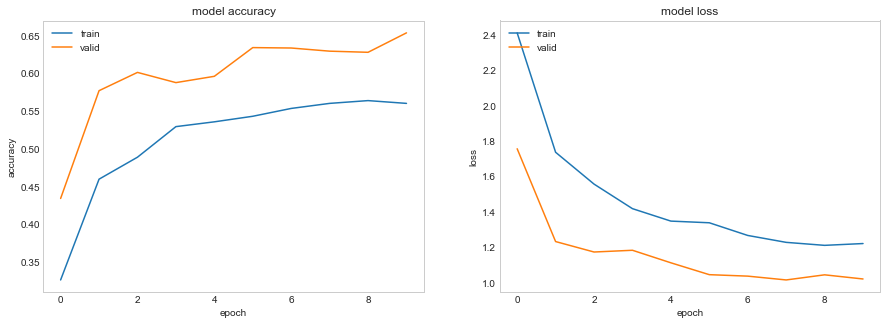

In [14]:
#define cnn model based on VGG16 architecture and pretrained weights with data augmentation technique
def data_augmentation_vgg16_model(train_img_features, encoded_train, valid_img_features, encoded_valid, test_data, test_file_names):
    #making an object of VGG-16 model from keras library
    vgg16_base_model = VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(256, 256, 3))
    #cutting of the output layer in VGG-16 so that we can connect the dense layer for our classification purposes
    output = vgg16_base_model.get_layer(index = -1).output  
    #flatten output from matrix to a vector so that it can be passed to MLP
    output = Flatten()(output)
    #we add a fully-connected dense layer with 512 nodes and relu activation fn
    output = Dense(512,activation = "relu")(output)
    #add batch normalization layer
    output = BatchNormalization()(output)
    # add dropout to reduce effect of overfitting, its a regularization technique
    output = Dropout(0.5)(output)
    # add 8 nodes for output since we have 8 categories with a softmax activation fn
    output = Dense(8, activation='softmax')(output)
    #combines input and output layers to form a model
    model = Model(vgg16_base_model.input, output)
    #traverse the model layers and set the first layers to not trainable as it already has pretrained weights
    for l in vgg16_base_model.layers:
        l.trainable = False
    #use a adam optimizer, with categorical crossentropy loss fn and metric as accuracy
    model.compile(optimizer="adam",loss="categorical_crossentropy",metrics =["accuracy"])
    # Transform the images to prevent overfitting, this is the data augmentation technique
    train_img_datagen = ImageDataGenerator(shear_range=0.1, zoom_range=0.1, rotation_range=45, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, vertical_flip=True)
    val_img_datagen = ImageDataGenerator()
    #return history object for the fitted model
    history = model.fit_generator(train_img_datagen.flow(train_img_features, encoded_train, batch_size=32), nb_epoch=10,samples_per_epoch = 3019,                     
                  validation_data=val_img_datagen.flow(valid_img_features, encoded_valid ,batch_size=32,shuffle=False),
                nb_val_samples=758,callbacks = [EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto'),ModelCheckpoint("data_augmented_vgg16_weights.h5", monitor='val_acc', verbose = 1, save_best_only = True)])
    #load the best weights from the file
    model.load_weights("data_augmented_vgg16_weights.h5")
    #show confusion matrix on validation set
    validation_conf_matrix(model)
    #plot graphs for accuracy and validation log loss using history
    plot_graphs(history)
    
    #predict on the test set using predict proba which gives predictions in form of probabilities
    preds = best_model.predict_proba(test_data)
    clipped_preds = np.clip(preds,(1-0.82)/7,0.82)
    #make a submission dataframe as kaggle accepts it
    submission = pd.DataFrame(clipped_preds, columns= os.listdir("train/"))
    #insert test image file names in submission data frame as first column
    submission.insert(0, 'image', test_file_names)
    submission.head()
    #convert the submission dataframe into a csv file with a name
    submission.to_csv("data_augmented_vgg16_submission.csv",index = False)
    
#call the cnn model based on vgg-16 architecture
data_augmentation_vgg16_model(train_img_features, encoded_train, valid_img_features, encoded_valid, test_data, test_file_names)

## Inception-V3 CNN Model With Data Augmentation <a name="cnn_inceptionV3_data_augmentation"></a>

Epoch 1/5
94/94 [==============================] - 3284s - loss: 2.1261 - acc: 0.3620 - val_loss: 2.8548 - val_acc: 0.3300
Epoch 2/5
94/94 [==============================] - 3152s - loss: 1.6041 - acc: 0.4697 - val_loss: 1.4170 - val_acc: 0.5281
Epoch 3/5
94/94 [==============================] - 3146s - loss: 1.4855 - acc: 0.4876 - val_loss: 1.1968 - val_acc: 0.5799
Epoch 4/5
94/94 [==============================] - 3114s - loss: 1.4205 - acc: 0.5128 - val_loss: 1.1905 - val_acc: 0.5804
Epoch 5/5
758/758 [==============================] - 93s    

Accuracy-score:  0.580474934037


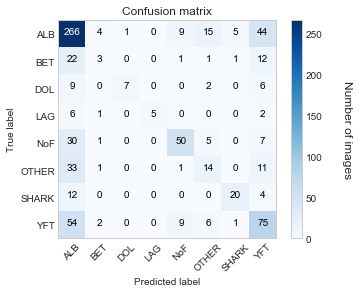

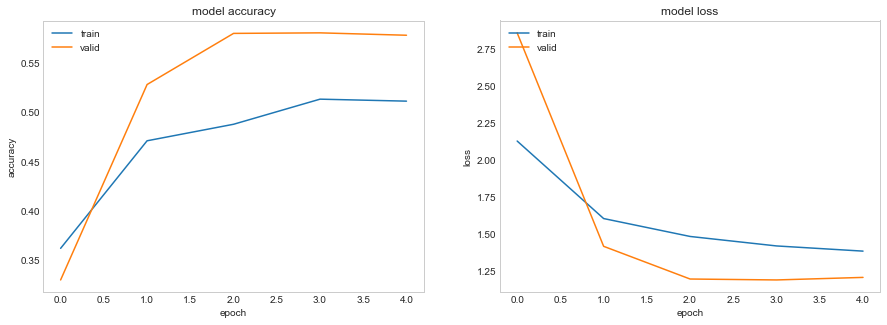

In [11]:
#define cnn model based on InceptionV3 architecture and pretrained weights with data augmentation technique
def data_augmentation_inceptionV3_model(train_img_features, encoded_train, valid_img_features, encoded_valid, test_data, test_file_names):
    #making an object of inceptionv3 model from keras library
    inceptionV3_base_model = InceptionV3(include_top=False, weights='imagenet', input_tensor=None, input_shape=(256, 256, 3))
    #cutting of the output layer in inceptionV3 so that we can connect the dense layer for our classification purposes
    output = inceptionV3_base_model.get_layer(index = -1).output  
    #flatten output from matrix to a vector so that it can be passed to MLP
    output = Flatten()(output)
    #we add a fully-connected dense layer with 512 nodes and relu activation fn
    output = Dense(512,activation = "relu")(output)
    #add batch normalization layer
    output = BatchNormalization()(output)
    # add dropout to reduce effect of overfitting, its a regularization technique
    output = Dropout(0.5)(output)
    # add 8 nodes for output since we have 8 categories with a softmax activation fn
    output = Dense(8, activation='softmax')(output)
    #combines input and output layers to form a model
    model = Model(inceptionV3_base_model.input, output)
    #traverse the model layers and set the first layers to not trainable as it already has pretrained weights
    for l in inceptionV3_base_model.layers:
        l.trainable = False

    #use a adam optimizer, with categorical crossentropy loss fn and metric as accuracy
    model.compile(optimizer="adam",loss="categorical_crossentropy",metrics =["accuracy"])
    # Transform the images to prevent overfitting, this is the data augmentation technique
    train_img_datagen = ImageDataGenerator(shear_range=0.1, zoom_range=0.1, rotation_range=45, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, vertical_flip=True)
    val_img_datagen = ImageDataGenerator()
    #return history object for the fitted model
    history = model.fit_generator(train_img_datagen.flow(train_img_features, encoded_train, batch_size=32), nb_epoch=10,samples_per_epoch = 3019,                     
                  validation_data=val_img_datagen.flow(valid_img_features, encoded_valid ,batch_size=32,shuffle=False),
                nb_val_samples=758,callbacks = [EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto'),ModelCheckpoint("data_augmented_InceptionV3_weights.h5", monitor='val_acc', verbose = 1, save_best_only = True)])
    #load the best weights from the file
    model.load_weights("data_augmented_InceptionV3_weights.h5")
    #show confusion matrix on validation set
    validation_conf_matrix(model)
    
    #plot graphs for accuracy and validation log loss using history
    plot_graphs(history)
    
    #predict on the test set using predict proba which gives predictions in form of probabilities
    preds = best_model.predict_proba(test_data)
    clipped_preds = np.clip(preds,(1-0.82)/7,0.82)
    #make a submission dataframe as kaggle accepts it
    submission = pd.DataFrame(clipped_preds, columns= os.listdir("train/"))
    #insert test image file names in submission data frame as first column
    submission.insert(0, 'image', test_file_names)
    submission.head()
    #convert the submission dataframe into a csv file with a name
    submission.to_csv("data_augmented_InceptionV3_submission.csv",index = False)

#call the cnn model based on inceptionV3 architecture
data_augmentation_inceptionV3_model(train_img_features, encoded_train, valid_img_features, encoded_valid, test_data, test_file_names)

## Multi-Layer Perceptron with Batch Normalization <a name="MLPBN"></a>

...
...
Train on 3019 samples, validate on 758 samples
Epoch 1/100
3019/3019 [==============================] - 11s - loss: 1.1635 - acc: 0.6790 - val_loss: 0.8312 - val_acc: 0.8061
Epoch 2/100
3019/3019 [==============================] - 10s - loss: 0.4417 - acc: 0.8708 - val_loss: 0.4744 - val_acc: 0.8562
Epoch 3/100
3019/3019 [==============================] - 10s - loss: 0.2559 - acc: 0.9261 - val_loss: 0.4273 - val_acc: 0.8931
Epoch 4/100
3019/3019 [==============================] - 10s - loss: 0.2164 - acc: 0.9407 - val_loss: 0.4522 - val_acc: 0.8786
Epoch 5/100
3019/3019 [==============================] - 10s - loss: 0.1758 - acc: 0.9487 - val_loss: 0.2955 - val_acc: 0.9261
Epoch 6/100
3019/3019 [==============================] - 10s - loss: 0.1234 - acc: 0.9632 - val_loss: 0.5595 - val_acc: 0.8681
Epoch 7/100
3019/3019 [==============================] - 10s - loss: 0.1555 - acc: 0.9589 - val_loss: 0.3464 - val_acc: 0.9248
Epoch 00006: early stopping
...
13056/13153 [===========

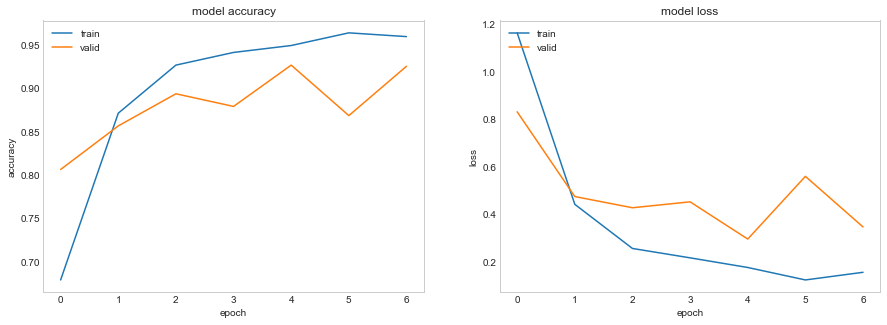

In [8]:
def MLP_batchNorm(train_img_features, encoded_train, valid_img_features, encoded_valid, test_data, test_file_names):
    
    # we creat a cnn model by initalizing it with a sequential model
    model = Sequential()
    #flatten the matrix to a vector so that it can be attached to MLP
    model.add(Flatten(input_shape=train_img_features.shape[1:]))
    #add a fully connected layer with 4096 nodes with relu activation fn
    model.add(Dense(4096, activation='relu'))
    #add batch normalization layer
    model.add(BatchNormalization())
    #add a fully connected layer with 512 nodes with relu activation fn
    model.add(Dense(512, activation='relu'))
    #add batch normalization layer
    model.add(BatchNormalization())
    # add dropout to reduce effect of overfitting, its a regularization technique
    model.add(Dropout(0.5))
    # add 8 nodes for output since we have 8 categories with a softmax activation fn
    model.add(Dense(8, activation='softmax'))
    #use a adam optimizer, with categorical crossentropy loss fn and metric as accuracy
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_img_features, encoded_train, batch_size=32, nb_epoch=100,
              validation_data=(valid_img_features,encoded_valid),shuffle=True,callbacks = [EarlyStopping(monitor='val_loss', patience=1, verbose=1, mode='auto'),ModelCheckpoint("fully_connected_MLP_batchNorm.h5", monitor='val_acc', verbose = 1, save_best_only = True)])
    #load the best weights from the file
    model.load_weights("fully_connected_MLP_batchNorm.h5")
    print("...")
    #show confusion matrix on validation set
    validation_conf_matrix(model)
    #predict on the test set using predict proba which gives predictions in form of probabilities
    preds = best_model.predict_proba(test_data)
    clipped_preds = np.clip(preds,(1-0.82)/7,0.82)
    #make a submission dataframe as kaggle accepts it
    submission = pd.DataFrame(clipped_preds, columns= os.listdir("train/"))
    #insert test image file names in submission data frame as first column
    submission.insert(0, 'image', test_file_names)
    submission.head()
    #convert the submission dataframe into a csv file with a name
    submission.to_csv("fully_connected_MLP_batchNorm_submission.csv",index = False)
    
    #plot graphs for accuracy and validation log loss using history
    plot_graphs(history)

#call MLP model with batch norm
MLP_batchNorm(train_img_features, encoded_train, valid_img_features, encoded_valid, test_data, test_file_names)


## Multi-Layer Perceptron with Batch Normalization & Dropout <a name="MLPBND"></a>

...
...
Train on 3019 samples, validate on 758 samples
Epoch 1/100
3019/3019 [==============================] - 12s - loss: 1.3680 - acc: 0.6161 - val_loss: 0.9710 - val_acc: 0.7467
Epoch 2/100
3019/3019 [==============================] - 11s - loss: 0.6842 - acc: 0.7986 - val_loss: 0.5447 - val_acc: 0.8443
Epoch 3/100
3019/3019 [==============================] - 10s - loss: 0.4305 - acc: 0.8735 - val_loss: 0.4615 - val_acc: 0.8786
Epoch 4/100
3019/3019 [==============================] - 10s - loss: 0.3223 - acc: 0.9016 - val_loss: 0.4395 - val_acc: 0.8747
Epoch 5/100
3019/3019 [==============================] - 10s - loss: 0.2510 - acc: 0.9261 - val_loss: 0.3817 - val_acc: 0.9024
Epoch 6/100
3019/3019 [==============================] - 10s - loss: 0.2379 - acc: 0.9318 - val_loss: 0.4005 - val_acc: 0.8879
Epoch 7/100
3019/3019 [==============================] - 10s - loss: 0.2025 - acc: 0.9414 - val_loss: 0.2922 - val_acc: 0.9235
Epoch 8/100
3019/3019 [==============================] -

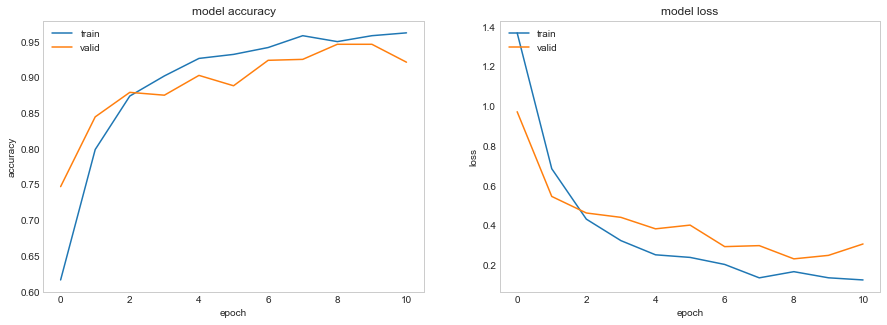

In [8]:
def fully_connected_MLP_batchNormWithDropout(train_img_features, encoded_train, valid_img_features, encoded_valid, test_data, test_file_names):
    # we creat a cnn model by initalizing it with a sequential model
    model = Sequential()
    #flatten the matrix to a vector so that it can be attached to MLP
    model.add(Flatten(input_shape=train_img_features.shape[1:]))
    #add a fully connected layer with 4096 nodes with relu activation fn
    model.add(Dense(4096, activation='relu'))
    #add batch normalization layer
    model.add(BatchNormalization())
    # add dropout to reduce effect of overfitting, its a regularization technique
    model.add(Dropout(0.2))
    #add a fully connected layer with 512 nodes with relu activation fn
    model.add(Dense(512, activation='relu'))
    #add batch normalization layer
    model.add(BatchNormalization())
    # add dropout to reduce effect of overfitting, its a regularization technique
    model.add(Dropout(0.3))
    # add 8 nodes for output since we have 8 categories with a softmax activation fn
    model.add(Dense(8, activation='softmax'))
    #use a adam optimizer, with categorical crossentropy loss fn and metric as accuracy
    model.compile(optimizer="adam",loss="categorical_crossentropy",metrics =["accuracy"])
    print("...")
    history = model.fit(train_img_features, encoded_train, batch_size=32, nb_epoch=100,
              validation_data=(valid_img_features,encoded_valid),shuffle=True,callbacks = [EarlyStopping(monitor='val_loss', patience=1, verbose=1, mode='auto'),ModelCheckpoint("fully_connected_MLP_batchNormWithDropout.h5", monitor='val_acc', verbose = 1, save_best_only = True)])
    #load the best weights from the file
    model.load_weights("fully_connected_MLP_batchNormWithDropout.h5")
    print("...")
    #show confusion matrix on validation set
    validation_conf_matrix(model)
    #predict on the test set using predict proba which gives predictions in form of probabilities
    preds = best_model.predict_proba(test_data)
    clipped_preds = np.clip(preds,(1-0.82)/7,0.82)
    #make a submission dataframe as kaggle accepts it
    submission = pd.DataFrame(clipped_preds, columns= os.listdir("train/"))
    #insert test image file names in submission data frame as first column
    submission.insert(0, 'image', test_file_names)
    submission.head()
    #convert the submission dataframe into a csv file with a name
    submission.to_csv("fully_connected_MLP_batchNormWithDropout_submission.csv",index = False)
    
    #plot graphs for accuracy and validation log loss using history
    plot_graphs(history)

#call MLP model with batch norm
MLP_batchNormWithDropout(train_img_features, encoded_train, valid_img_features, encoded_valid, test_data, test_file_names)
